In [1]:
gpu=4
CUDA_VISIBLE_DEVICES=gpu

In [2]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

# import osa
import shutil
import seaborn as sns
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
from glob import glob
from sklearn.metrics import roc_curve,auc, precision_score,precision_recall_curve,recall_score,precision_recall_fscore_support,confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import models
from prettytable import PrettyTable
print(torch.cuda.is_available())
import warnings
warnings.filterwarnings("ignore")
# import pandas as pd
print(torch.cuda.get_device_properties(0).total_memory)
print(torch.cuda.memory_allocated())
gpu_id = gpu

True
11721506816
0


In [3]:
train_df=pd.read_csv("/DATA/chowdari1/DATA/csv/ppr_nih_train.csv")
val_df=pd.read_csv("/DATA/chowdari1/DATA/csv/ppr_nih_val.csv")
test_df=pd.read_csv("/DATA/chowdari1/DATA/csv/ppr_nih_test.csv")
train_df=train_df.sample(frac=1,random_state=172)
val_df=val_df.sample(frac=1,random_state=172)
test_df=test_df.sample(frac=1,random_state=172)

In [4]:
# val_df.head()

In [5]:
# val_df.head()

In [6]:
# train_df=train_df.sample(frac=1,random_state=172)
# val_df=val_df.sample(frac=1,random_state=172)

In [7]:
train_df.head()

,Unnamed: 0,Image index,target,path
6421,6421,00019823_001.png,1,/DATA/chowdari1/DATA/dataset/nih/images_009/im...
5833,5833,00018194_000.png,0,/DATA/chowdari1/DATA/dataset/nih/images_008/im...
4382,4382,00014840_000.png,0,/DATA/chowdari1/DATA/dataset/nih/images_007/im...
1977,1977,00007292_003.png,1,/DATA/chowdari1/DATA/dataset/nih/images_004/im...
2409,2409,00009191_000.png,1,/DATA/chowdari1/DATA/dataset/nih/images_004/im...


In [8]:

# for i in range(df.shape[0]):
#     df['path'][i]+='.png'
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, df, img_dir, transform,start,count):
        self.ipaths = df["path"][start:count].to_numpy()
        self.target=df["target"][start:count].to_numpy()
        self.transform = transform
        self.count=count
        self.img_dir=img_dir


    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        img_path=self.img_dir+self.ipaths[idx]
        image = Image.open(img_path).convert('RGB')
        label=self.target[idx]
        image = self.transform(image)
        return image, label

In [9]:
# df.iloc[0]

In [10]:
# # normalizer=[[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
# # transformations = {
# # 		'train': transforms.Compose([
# # 			transforms.Resize(256),
# # 			transforms.CenterCrop(224),
# # 			transforms.RandomHorizontalFlip(),
# # 			transforms.ColorJitter(brightness=0.25, contrast=0.25),
# # 			transforms.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
# # 			transforms.ToTensor(),
# # 			transforms.Normalize(normalizer[0], normalizer[1])]),
# # 		'val': transforms.Compose([
# # 			transforms.Resize(256),
# # 			transforms.CenterCrop(224),
# # 			transforms.ToTensor(),
# # 			transforms.Normalize(normalizer[0], normalizer[1])]),
# # 		'test': transforms.Compose([
# # 		transforms.Resize(256),
# # 		transforms.CenterCrop(224),
# # 		transforms.ToTensor(),
# # 		transforms.Normalize(normalizer[0], normalizer[1])])	
# # 			}

# # transform=transforms.Compose([
# #                             #   transforms.ToPILImage(),
# #                               transforms.Grayscale(num_output_channels=1),
# #                               transforms.Resize(256),
# #                               transforms.CenterCrop(224),
# #                               transforms.RandomHorizontalFlip(),
# #                               transforms.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
# #                               transforms.ToTensor(),                              
# # 							  transforms.Normalize((0.449,),(0.226,))
# # ])


# transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
#     transforms.Resize(32),
#     transforms.CenterCrop(28),
#     transforms.ToTensor(),
# ])

# # Set the train transform




In [11]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.449,),(0.226,))
])

In [12]:
train_df.shape, val_df.shape

((8574, 4), (1706, 4))

In [13]:
# train_data=CustomImageDataset(df,'/DATA/dataset/vinbig/vinbig/trainpng/',transform,4864+256-64+5,7168-64+5)
# valid_data=CustomImageDataset(df,'/DATA/dataset/vinbig/vinbig/trainpng/',transform,7168,7168+1280)
train_data=CustomImageDataset(train_df,'',transform,0,6400)
valid_data=CustomImageDataset(val_df,'',transform,0,1536)
# test_data=CustomImageDataset(df,'/DATA/dataset/vinbig/vinbig/trainpng/',transform,7000+6000,df.shape[0])
print(len(train_data))
# print(len(test_data))
trainloader=torch.utils.data.DataLoader(train_data, batch_size=256)
valloader=torch.utils.data.DataLoader(valid_data, batch_size=256)
# testloader=torch.utils.data.DataLoader(test_data, batch_size=256)
print(trainloader)
# print(len(testloader))
# dataloaders = {"train":trainloader, "val":valloader, "test": testloader}
dataloaders = {"train":trainloader, "val":valloader}
# data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val','test']}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}

data_sizes

6400


{'train': 6400, 'val': 1536}

In [14]:
# latent_dims=4
# conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
#         # out_width = (28+2-5)/2+1 = 27/2+1 = 13
# conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
# batch2 = nn.BatchNorm2d(16)
# conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
# # out_width = (14-5)/2+1 = 5
# #self.drop1=nn.Dropout2d(p=0.3) 
# # 6 * 6 * 16 = 576
# # linear1 = nn.Linear(186624, 224)
# linear1 = nn.Linear(23328, 224)
# linear2 = nn.Linear(224, latent_dims)
# linear3 = nn.Linear(224, latent_dims)

In [15]:
# load=valloader

In [16]:
# # load=conv1(load)
# for x, lab in tqdm.tqdm(load, desc='load', leave=False):
#     y=x
#     print(x.shape)
#     x = F.relu(conv1(x))
#     print(x.shape)
#     x = F.relu(batch2(conv2(x)))
#     print(x.shape)
#     x = F.relu(conv3(x))
#     print(x.shape)
#     #print(x.shape)
#     x = torch.flatten(x, start_dim=1)
#     print(x.shape)
#     #print(x.shape)
#     x = F.relu(linear1(x))
#     print(x.shape)
#     mu =  linear2(x)
#     print(mu.shape)
#     sigma = torch.exp(linear3(x))
#     print(sigma.shape)
#     # Apply linear layers
#     x = decoder_lin(sigma)
#     print(x.shape)
#     # Unflatten
#     x = unflatten(x)
#     print(x.shape)
#     # Apply transposed convolutions
#     x = decoder_conv(x)
#     print(x.shape)
#     # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
#     x = torch.sigmoid(x)
#     print(x.shape)
#     # plt.imshow(x,cmap='gray')
#     break

In [17]:
# print(type(x))

In [18]:
# x.detach().numpy()

In [19]:
# # test_dataset=CustomImageDataset(df,'/DATA/dataset/vinbig/vinbig/trainpng/',transform,7000+6000,df.shape[0])
# def plot_ae_outputs(encoder,decoder,n=5):
#     plt.figure(figsize=(10,4.5))
#     for i in range(n):
#       ax = plt.subplot(2,n,i+1)
#       img = valid_data[i][0].unsqueeze(0).to(device)
#       encoder.eval()
#       decoder.eval()
#       with torch.no_grad():
#          rec_img  = decoder(encoder(img))
#          print(img,rec_img)
#       plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
#       ax.get_xaxis().set_visible(False)
#       ax.get_yaxis().set_visible(False)  
#       if i == n//2:
#         ax.set_title('Original images')
#       ax = plt.subplot(2, n, i + 1 + n)
#       plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
#       ax.get_xaxis().set_visible(False)
#       ax.get_yaxis().set_visible(False)  
#       if i == n//2:
#          ax.set_title('Reconstructed images')
#     plt.show() 

In [20]:
# y=valid_data[0][0].unsqueeze(0)
# y=y.to('cuda')
# print(y,y.shape)
# print(type(y))
# ve=ve.to(device)
# with torch.no_grad():
#     # vae.encoder.eval()
#     ve.eval()
#     y=ve(y)
# print(y,y.shape)
# de=de.to(device)
# y=de(y)
# print(y,y.shape)
    

In [21]:
# loss = ((valid_data[0][0].unsqueeze(0) - y.to('cpu'))**2).sum() + ve.kl

In [22]:
# loss

In [23]:
# plt.imshow(valid_data[0][0].unsqueeze(0).cpu().squeeze().numpy(), cmap='gist_gray')

In [24]:
# # y=

# plt.imshow(x[0].cpu().squeeze().detach().numpy(), cmap='gist_gray')

In [25]:
# y=

# plt.imshow(x[0].cpu().squeeze().detach().numpy(), cmap='gist_gray')

In [26]:
# y=

# plt.imshow(y[0].cpu().squeeze().detach().numpy(), cmap='gist_gray')

In [27]:
# de=Decoder(4)

In [28]:
# ve= VariationalEncoder(4)

In [29]:
# plot_ae_outputs(vae.encoder,vae.decoder,n=1)

In [30]:
# plt.imshow(x.detach().numpy()[0][0],cmap='gray')

In [31]:
# # x = x.to(device)
# x = F.relu(conv1(x))
# x = F.relu(batch2(conv2(x)))
# x = F.relu(conv3(x))
# #print(x.shape)
# x = torch.flatten(x, start_dim=1)
# #print(x.shape)
# x = F.relu(linear1(x))

In [32]:
# pip install --upgrade pytorch=1.5.0
# pip install  torch==1.5.0 

In [33]:
# import torch
# torch.__version__

In [34]:
# conda --version

In [35]:
# latent_dims=4 
#         ### Linear section
# decoder_lin = nn.Sequential(
#     # First linear layer
#     nn.Linear(latent_dims, 224),
#     nn.ReLU(True),
#     # Second linear layer
#     nn.Linear(224, 23328),
#     nn.ReLU(True)
# )

# ### Unflatten
# unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 27, 27))

# ### Convolutional section
# decoder_conv = nn.Sequential(
#     # First transposed convolution
#     nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1),
#     nn.BatchNorm2d(16),
#     nn.ReLU(True),
#     # Second transposed convolution
#     nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
#     nn.BatchNorm2d(8),
#     nn.ReLU(True),
#     # Third transposed convolution
#     nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
# )
        


In [36]:
import torch
torch.cuda.empty_cache()
device=torch.device("cuda:4")
print("Training on GPU... Ready for HyperJump...")

Training on GPU... Ready for HyperJump...


In [37]:
torch.cuda.set_device(gpu_id)

In [38]:
for img,label in trainloader:
  print(img.shape)
  break
for img,label in valloader:
  print(img.shape)
  break

torch.Size([256, 1, 224, 224])
torch.Size([256, 1, 224, 224])


In [39]:
# en=0
# de=0

In [40]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        # out_width = (28+2-5)/2+1 = 27/2+1 = 13
        self.conv2 = nn.Conv2d(8,16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        # out_width = (14-5)/2+1 = 5
        #self.drop1=nn.Dropout2d(p=0.3) 
        # 6 * 6 * 16 = 576
        self.linear1 = nn.Linear(23328, 224)
        self.linear2 = nn.Linear(224, latent_dims)
        self.linear3 = nn.Linear(224, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        #print(x.shape)
        global en
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        # print(en,'hello',z[0])
        # en+=1
        return z

In [41]:
# class VariationalEncoder(nn.Module):
#     def __init__(self, latent_dims):
#         super(VariationalEncoder, self).__init__()
#         self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
#         # out_width = (28+2-5)/2+1 = 27/2+1 = 13
#         self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
#         self.batch2 = nn.BatchNorm2d(16)
#         self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
#         # out_width = (14-5)/2+1 = 5
#         #self.drop1=nn.Dropout2d(p=0.3) 
#         # 6 * 6 * 16 = 576
#         self.linear1 = nn.Linear(3*3*32, 128)
#         self.linear2 = nn.Linear(128, latent_dims)
#         self.linear3 = nn.Linear(128, latent_dims)

#         self.N = torch.distributions.Normal(0, 1)
#         self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
#         self.N.scale = self.N.scale.cuda()
#         self.kl = 0

#     def forward(self, x):
#         #print(x.shape)
#         x = x.to(device)
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.batch2(self.conv2(x)))
#         x = F.relu(self.conv3(x))
#         #print(x.shape)
#         x = torch.flatten(x, start_dim=1)
#         #print(x.shape)
#         x = F.relu(self.linear1(x))
#         mu =  self.linear2(x)
#         sigma = torch.exp(self.linear3(x))
#         z = mu + sigma*self.N.sample(mu.shape)
#         self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
#         return z

In [42]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(latent_dims, 224),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(224, 23328),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 27, 27))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        global de
        # Apply linear layers
        x = self.decoder_lin(x)
        # print('de1',x)
        # Unflatten
        x = self.unflatten(x)
        # print('de2',x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # print('de3',x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        # print(de,'de4',x[0][0][0][0])
        # de+=1
        return x

In [43]:
# class Decoder(nn.Module):
    
#     def __init__(self, latent_dims):
#         super().__init__()

#         ### Linear section
#         self.decoder_lin = nn.Sequential(
#             # First linear layer
#             nn.Linear(latent_dims, 128),
#             nn.ReLU(True),
#             # Second linear layer
#             nn.Linear(128, 3 * 3 * 32),
#             nn.ReLU(True)
#         )

#         ### Unflatten
#         self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

#         ### Convolutional section
#         self.decoder_conv = nn.Sequential(
#             # First transposed convolution
#             nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
#             nn.BatchNorm2d(16),
#             nn.ReLU(True),
#             # Second transposed convolution
#             nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
#             nn.BatchNorm2d(8),
#             nn.ReLU(True),
#             # Third transposed convolution
#             nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
#         )
        
#     def forward(self, x):
#         # Apply linear layers
#         x = self.decoder_lin(x)
#         # Unflatten
#         x = self.unflatten(x)
#         # Apply transposed convolutions
#         x = self.decoder_conv(x)
#         # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
#         x = torch.sigmoid(x)
#         return x

In [44]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        # print(z)
        return self.decoder(z)

In [45]:
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=23328, out_features=224, bias=True)
    (linear2): Linear(in_features=224, out_features=4, bias=True)
    (linear3): Linear(in_features=224, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=224, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=224, out_features=23328, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 27, 27))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), output_padd

In [46]:
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    phase='train'
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    # for x, _ in dataloader: 
    for x, _ in tqdm.tqdm(dataloader, desc=phase, leave=False):
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [47]:
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    phase='test'
    with torch.no_grad(): # No need to track the gradients
        for x, _ in tqdm.tqdm(dataloader, desc=phase, leave=False):
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [48]:
test_dataset=CustomImageDataset(test_df,'',transform,0,256)
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show() 

In [49]:
# num_epochs = 10
import datetime
def train(vae,num_epochs):
    best_test_loss = float('inf')
    best_model_wts = copy.deepcopy(vae.state_dict())
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format( epoch+1, num_epochs))       
        print (datetime. datetime. now())
        print('-' * 10)
        train_loss = train_epoch(vae,device,trainloader,optim)
        val_loss = test_epoch(vae,device,valloader)
        if(best_test_loss > val_loss):
            best_test_loss=val_loss
            best_model_wts = copy.deepcopy(vae.state_dict())
        print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    print('best_test_loss: ',best_test_loss)
    plot_ae_outputs(vae.encoder,vae.decoder,n=5)

    vae.load_state_dict(best_model_wts)
    return vae

Epoch 1/2
2022-01-25 03:20:31.281416
----------



 EPOCH 1/2 	 train loss 50032.895 	 val loss 49764.402
Epoch 2/2
2022-01-25 03:31:46.420626
----------



 EPOCH 2/2 	 train loss 44357.089 	 val loss 42486.460
best_test_loss:  42486.459635416664


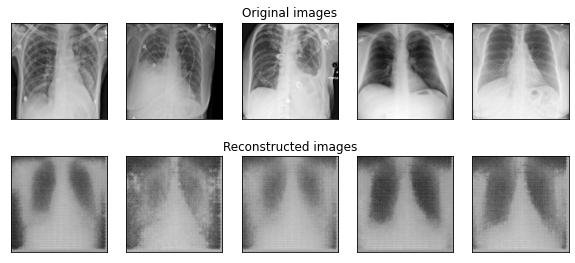

In [44]:
va=train(vae,2)


 EPOCH 1/10 	 train loss 125833.314 	 val loss 64299.464



 EPOCH 2/10 	 train loss 56953.777 	 val loss 57817.296



 EPOCH 3/10 	 train loss 50700.179 	 val loss 47559.648



 EPOCH 4/10 	 train loss 45593.490 	 val loss 43215.110



 EPOCH 5/10 	 train loss 42020.160 	 val loss 40617.618



 EPOCH 6/10 	 train loss 39744.623 	 val loss 39066.433



 EPOCH 7/10 	 train loss 38146.392 	 val loss 37645.949



 EPOCH 8/10 	 train loss 37000.846 	 val loss 36644.091



 EPOCH 9/10 	 train loss 36185.411 	 val loss 35879.437



 EPOCH 10/10 	 train loss 35511.643 	 val loss 35321.223


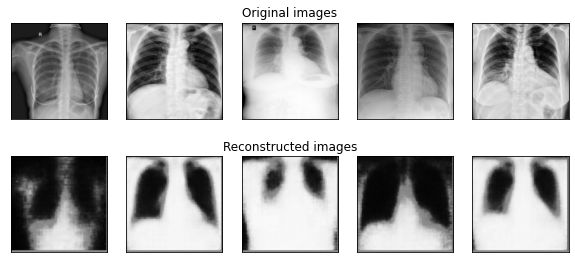

In [23]:
num_epochs = 10
for epoch in range(num_epochs):

   train_loss = train_epoch(vae,device,trainloader,optim)
   val_loss = test_epoch(vae,device,valloader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

plot_ae_outputs(vae.encoder,vae.decoder,n=5)

In [25]:
path="/DATA/radhasyam1/saved_models/vae.pth"
torch.save(vae.state_dict(), path)

In [50]:
path='/DATA/chowdari1/saved_models/vae/vae_big_nihppr_100ep.pth'
# model=densenet_Model(pretrained=True)
model= VariationalAutoencoder(latent_dims=d)
x_model=torch.load(path,map_location='cpu')
# x_model=x_model.to(device)
model.load_state_dict(x_model)
model=model.to(device)
model.eval()
print(path)

/DATA/chowdari1/saved_models/vae/vae_big_nihppr_100ep.pth


In [52]:
test_loss = test_epoch(model,device,testloader)
test_loss

21651.47109375

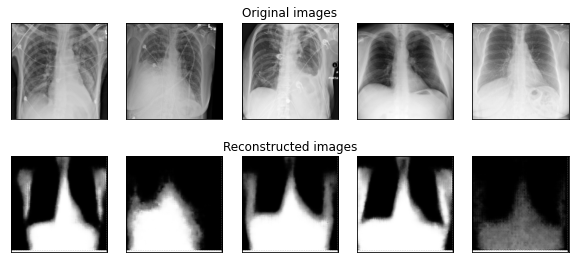

In [53]:
plot_ae_outputs(model.encoder,model.decoder,n=5)

In [48]:
test_loss = test_epoch(va,device,testloader)
test_loss

36669.517578125

In [46]:
test_df.shape

(1344, 4)

In [51]:
test_data=CustomImageDataset(test_df,'',transform,0,1280)
testloader=torch.utils.data.DataLoader(test_data, batch_size=256)
len(testloader.sampler)

1280